# Modeling health indicators and distance from airport

Hypotheses: 
- Null hypothesis: There is no relationship between health outcome indicators by CCG and the CCG’s distance from the airport  
- Alternative hypothesis: There is a relationship between a CCG’s health outcome indicators and its distance from the airport. Our team expects to see a relationship where health outcomes are worse closer to the airport. 

Data: 
- Health outcome indicators: mortality rates from five conditions, prevalence of nine conditions, and hospital admission rates for eleven conditions - all reported by Clinical Commission Groups (CCGs) 
- CCGs’ distance from airport: calculated from the geographic middle of the CCG

### Load and overview data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

from scipy import stats
from statsmodels.formula.api import ols


In [6]:
# load in data 
health = pd.read_csv('../data_final/health_data_final.csv')
health.head(3)

,Unnamed: 0,Year,Indicator Type,Indicator Name,Area Name,Radius Location,Value,heathrow_distance,LAT,LONG
0,0,2006,Health - Mortality,Under 75 Resp Disease Mortality Rate,NHS Ealing CCG,Inner,38.388443,11465.530930,51.5244,-0.31405
1,1,2006,Health - Mortality,Under 75 Resp Disease Mortality Rate,NHS Hillingdon CCG,Inner,36.176786,7458.185529,51.5366,-0.44180
2,2,2006,Health - Mortality,Under 75 Resp Disease Mortality Rate,NHS Hounslow CCG,Inner,39.003001,5336.984712,51.4624,-0.37847


In [7]:
# breakdown of health indicators 
health[["Indicator Type", "Indicator Name", "Value"]].groupby(["Indicator Type", "Indicator Name"]).count()

Value
Indicator Type      Indicator Name                          
Health - Mortality  <75 Coronary Heart Disease           780
                    Asthma                               352
                    COPD (contributory cause)            376
                    Pneumonia (all mentions)             376
                    Under 75 Resp Disease                376
Health - Prevalence Asthma Prevalence                    175
                    Atrial Fibrillation Prevalence       175
                    CHD Prevalence                       175
                    CKD Prevalence                       159
                    COPD Prevalence                      145
                    Diabetes Prevalence                  175
                    Heart Failure Prevalence             175
                    Hypertension Prevalence              175
                    Stroke: Prevalence                   175
Health- Admission   Asthma Admissions Over 19yr           96
                    Asthma Admissions Under 19yr          96
                    CHD Admissions                       272
                    COPD Admissions                       96
                    Heart Failure Admissions             272
                    Pneumonia Admissions                  96
                    Respiratory Admissions                96
                    Respiratory Tract Admissions 1yr      62
                    Respiratory Tract Admissions U1yr     96
                    Stroke Admissions                     81
                    Stroke Atrial Fib Admissions          68

In [8]:
# list CCGs
health["Area Name"].unique()

array(['NHS Ealing CCG', 'NHS Hillingdon CCG', 'NHS Hounslow CCG',
       'NHS Buckinghamshire CCG', 'NHS East Berkshire CCG',
       'NHS North West Surrey CCG', 'NHS Brent CCG',
       'NHS Hammersmith And Fulham CCG', 'NHS Harrow CCG',
       'NHS Herts Valleys CCG', 'NHS Oxfordshire CCG',
       'NHS Surrey Heath CCG', 'NHS Berkshire West CCG',
       'NHS Croydon CCG', 'NHS Kingston CCG', 'NHS Merton CCG',
       'NHS Richmond CCG', 'NHS Sutton CCG', 'NHS Wandsworth CCG',
       'NHS Guildford and Waverley CCG'], dtype=object)

### Check out distribution of data

In [9]:
indicators = list(health["Indicator Name"].unique())

<ipython-input-10-e06257a47234>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))
<ipython-input-10-e06257a47234>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))
<ipython-input-10-e06257a47234>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))
<ipy

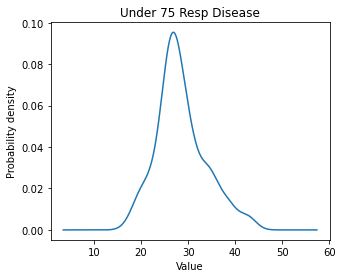

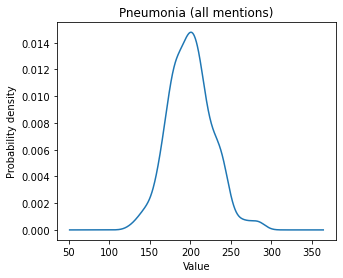

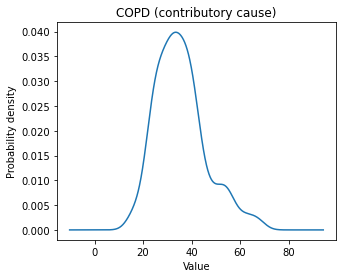

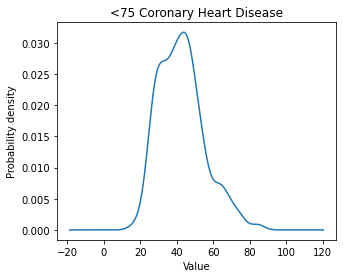

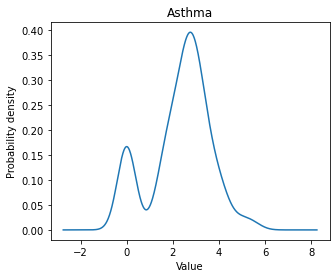

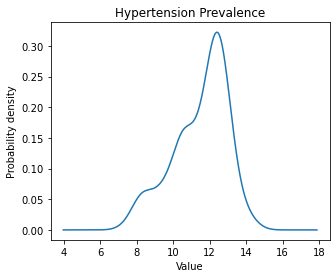

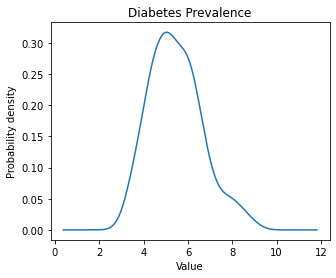

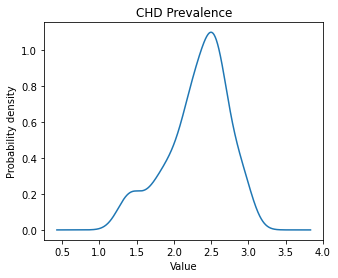

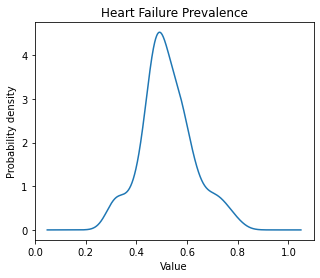

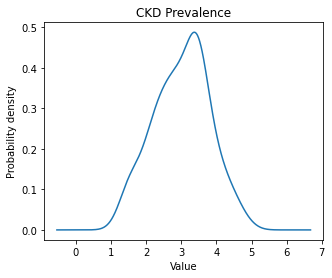

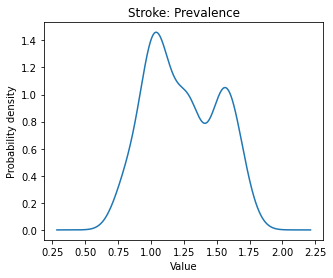

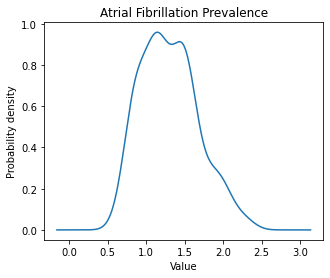

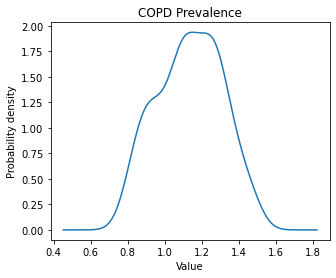

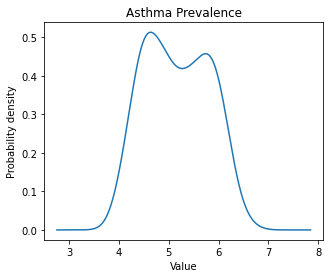

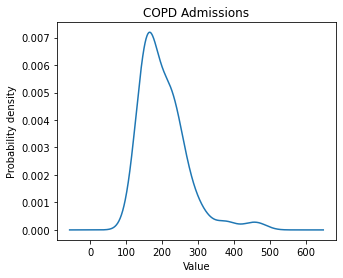

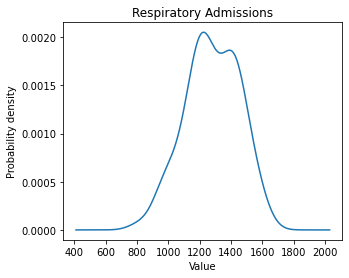

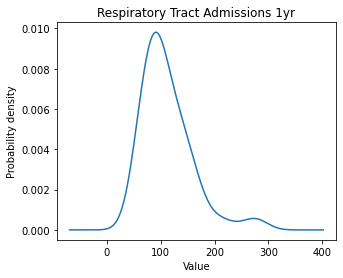

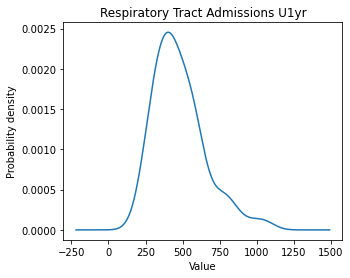

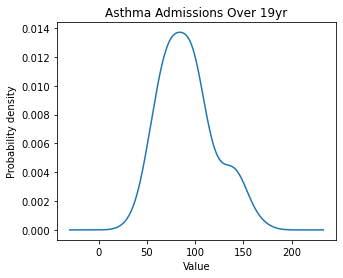

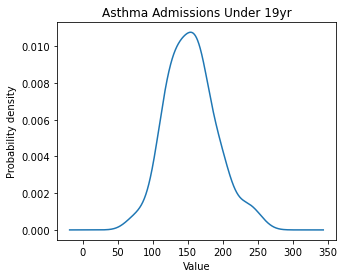

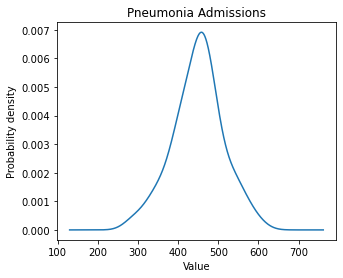

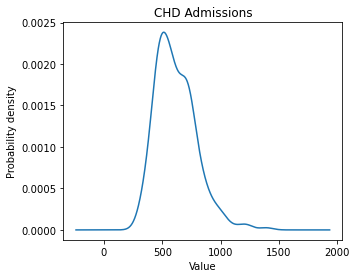

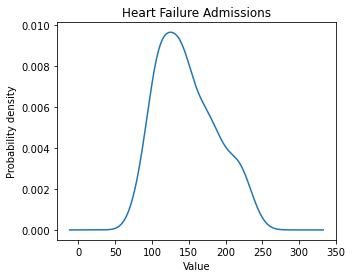

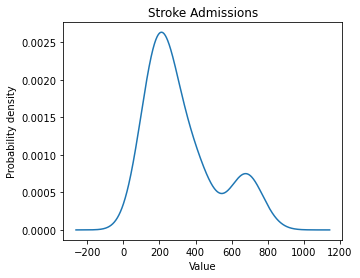

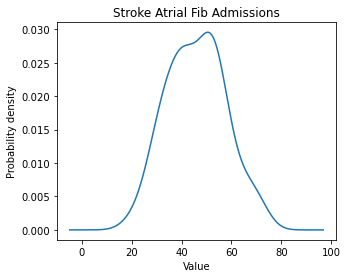

In [10]:
for i in indicators:
    plt.figure(figsize=(5,4))
    temp_df = health[health["Indicator Name"] == i]
    ax = temp_df["Value"].plot.density()
    ax.set_title(i)
    ax.set_xlabel("Value")
    ax.set_ylabel("Probability density")

Asthma mortality rates, asthma prevalence, stroke admissions, and stroke prevalance do not appear to have normal distributions. Let's check that mathematically:

In [11]:
for i in indicators: 
    print("\nSUMMARY STARTS FOR:", i)
    temp_df = health[health["Indicator Name"] == i]
    print("mean:", temp_df["Value"].mean())
    print("median:", temp_df["Value"].median())
    print("mode:", temp_df["Value"].mode()[0])


SUMMARY STARTS FOR: Under 75 Resp Disease
mean: 28.523919513475782
median: 27.6440717579672
mode: 17.639180647842696

SUMMARY STARTS FOR: Pneumonia (all mentions)
mean: 200.12074848696992
median: 199.18078523251052
mode: 129.262312978043

SUMMARY STARTS FOR: COPD (contributory cause)
mean: 35.49113835471698
median: 33.98833465534855
mode: 15.8633098720506

SUMMARY STARTS FOR: <75 Coronary Heart Disease
mean: 42.598910256410214
median: 41.5
mode: 43.36

SUMMARY STARTS FOR: Asthma
mean: 2.3454339378097626
median: 2.58991912375598
mode: 0.0

SUMMARY STARTS FOR: Hypertension Prevalence
mean: 11.49483402308322
median: 11.937490749184699
mode: 7.45782717749471

SUMMARY STARTS FOR: Diabetes Prevalence
mean: 5.4500030265340005
median: 5.32048087587641
mode: 3.23599099682924

SUMMARY STARTS FOR: CHD Prevalence
mean: 2.318719707062632
median: 2.4086087261684304
mode: 1.28067673240545

SUMMARY STARTS FOR: Heart Failure Prevalence
mean: 0.5216641801452875
median: 0.505813709440457
mode: 0.2981104

SUMMARY STARTS FOR DIST VARIABLE:
mean: 22982.010874023494
median: 16573.145489786915
mode: 5336.9847118736625


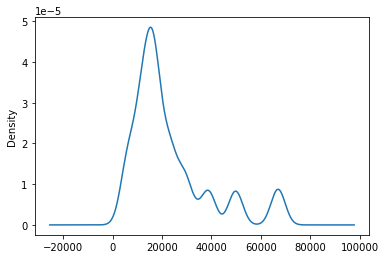

In [12]:
health["heathrow_distance"].plot.density()

print("SUMMARY STARTS FOR DIST VARIABLE:")
print("mean:", health["heathrow_distance"].mean())
print("median:", health["heathrow_distance"].median())
print("mode:", health["heathrow_distance"].mode()[0])

Findings on distribution: 
- Just by looking at the PDFs, asthma mortality rates, asthma prevalence, stroke admissions, and stroke prevalance do not appear to have normal distributions.
- The distance from airport variable appears to have a non-normal distribution (skewed right)

Next steps: 
- How do we determine if the distribution is close enough to normal to use linear regression?
- If the data is not normal, do we need to use logistic regression instead?

### T-test for health indicators in inner versus outer radius CCGs

In [13]:
for i in indicators: 
    print("\nP-value for " + i + " between inner and outer")
    temp_df = health[health["Indicator Name"] == i]
    
    inner = temp_df[temp_df["Radius Location"] == "Inner"].Value
    outer = temp_df[temp_df["Radius Location"] == "Outer"].Value
    
    statistic, pvalue = stats.ttest_ind(inner,outer, equal_var=False)
    print(pvalue)


P-value for Under 75 Resp Disease between inner and outer
5.019019150199857e-07

P-value for Pneumonia (all mentions) between inner and outer
2.8921642521998514e-08

P-value for COPD (contributory cause) between inner and outer
0.01917839836600237

P-value for <75 Coronary Heart Disease between inner and outer
7.38287379258602e-08

P-value for Asthma between inner and outer
0.00012087205324299837

P-value for Hypertension Prevalence between inner and outer
0.9568119688273695

P-value for Diabetes Prevalence between inner and outer
0.001245657230715087

P-value for CHD Prevalence between inner and outer
0.593773501288982

P-value for Heart Failure Prevalence between inner and outer
0.04737665094262989

P-value for CKD Prevalence between inner and outer
0.03034819221053463

P-value for Stroke: Prevalence between inner and outer
1.3521692131485727e-05

P-value for Atrial Fibrillation Prevalence between inner and outer
0.027746089418433977

P-value for COPD Prevalence between inner and ou

### Correlation coefficiences

In [5]:
print("CORRELATION COEFFICIENTS ARE AS FOLLOWS:")

for i in indicators: 
    temp_df = health[health["Indicator Name"] == i]
    
    print(i, ":", temp_df.corr()['heathrow_distance']["Value"])

CORRELATION COEFFICIENTS ARE AS FOLLOWS:
Under 75 Resp Disease : -0.38538497578279923
Pneumonia (all mentions) : -0.2598922286353997
COPD (contributory cause) : -0.20860859945490748
<75 Coronary Heart Disease : -0.3500279819345199
Asthma : -0.07020248691492569
Hypertension Prevalence : 0.27936512444412587
Diabetes Prevalence : -0.29879861839966965
CHD Prevalence : 0.25643765708694055
Heart Failure Prevalence : 0.3961435642988723
CKD Prevalence : 0.44785472338949633
Stroke: Prevalence : 0.5847861842162376
Atrial Fibrillation Prevalence : 0.4375472725933319
COPD Prevalence : 0.4171258765101228
Asthma Prevalence : 0.6791519881793964
COPD Admissions : -0.31536601687927635
Respiratory Admissions : -0.3155769912604171
Respiratory Tract Admissions 1yr : 0.03523142426370236
Respiratory Tract Admissions U1yr : 0.26793880064910225
Asthma Admissions Over 19yr : -0.3725966117642728
Asthma Admissions Under 19yr : -0.2257069563230455
Pneumonia Admissions : -0.3995592008716842
CHD Admissions : -0.488

For most health indicators and distance from airport, the correlation coefficient is between 0.5 and -0.5.

Asthna prevalance (R=0.68), stroke prevalence (R=0.58), and stroke admissions (R=0.61) are higher further away from the airport. 

### Linear regression: line of best fit

<ipython-input-14-a0323d083e0f>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,5))
<ipython-input-14-a0323d083e0f>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,5))
<ipython-input-14-a0323d083e0f>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,5))
<ipy

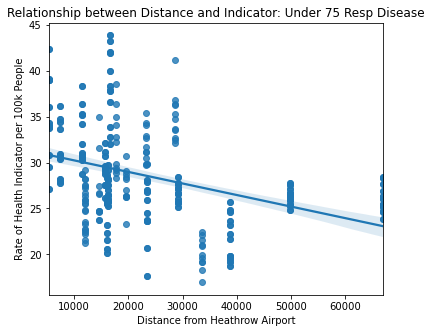

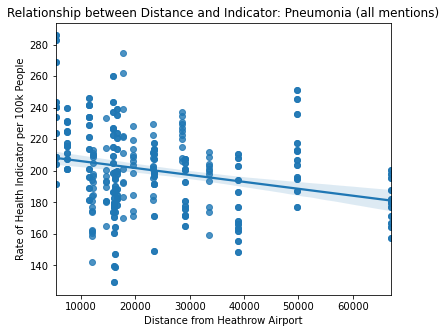

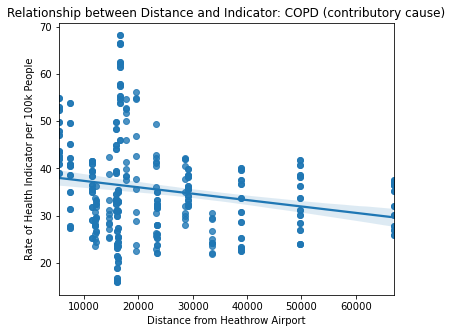

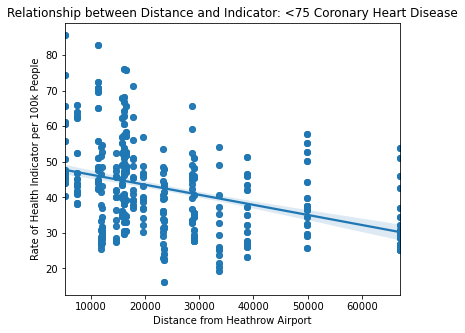

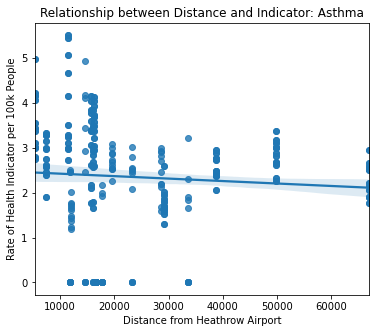

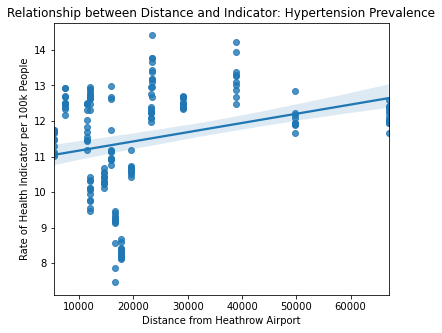

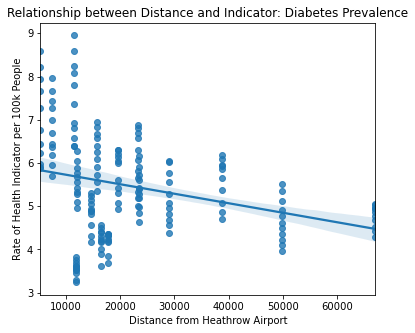

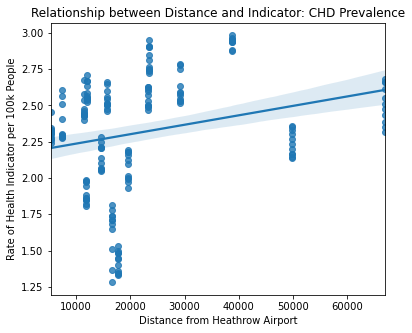

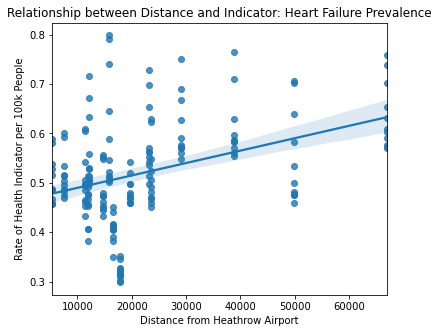

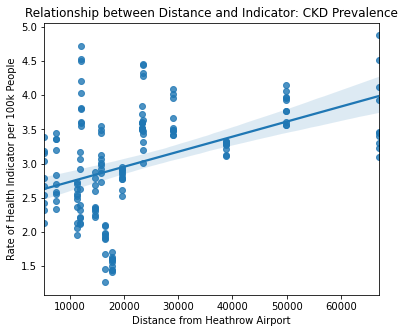

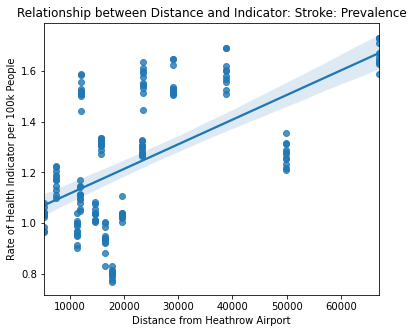

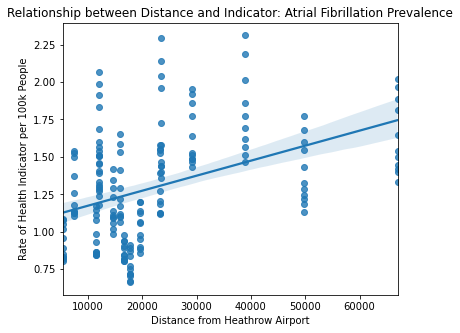

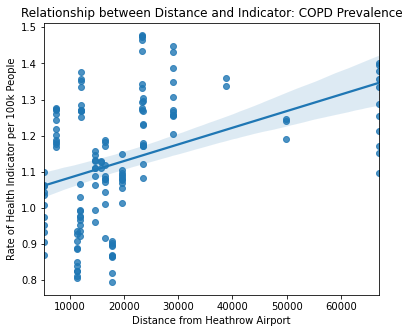

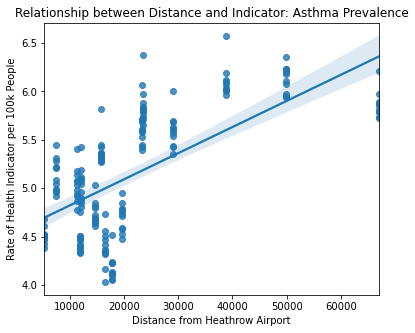

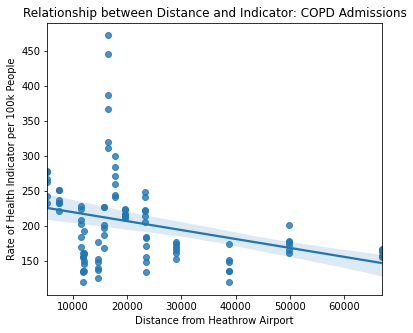

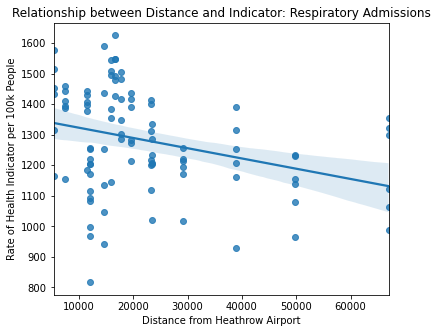

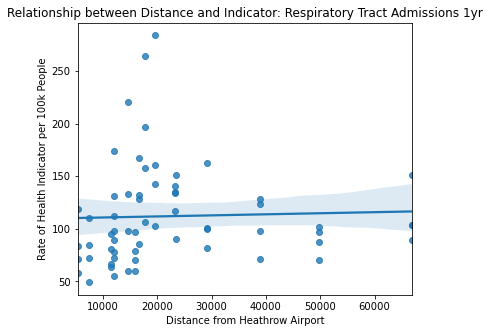

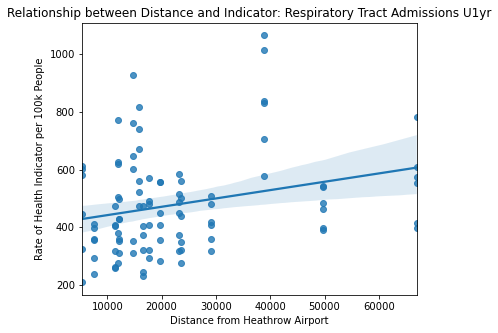

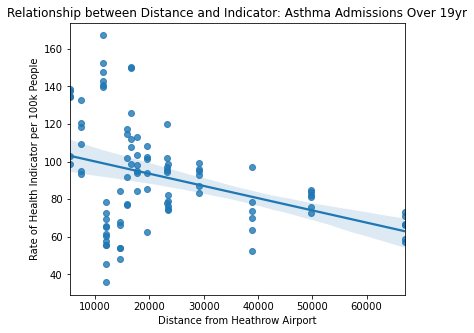

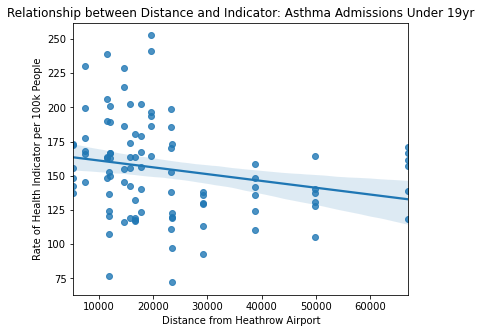

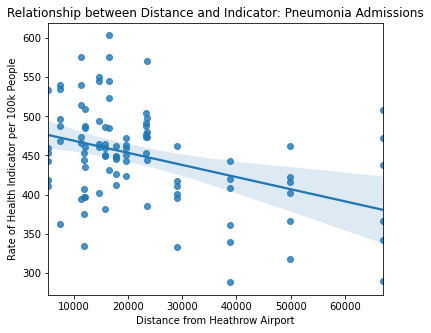

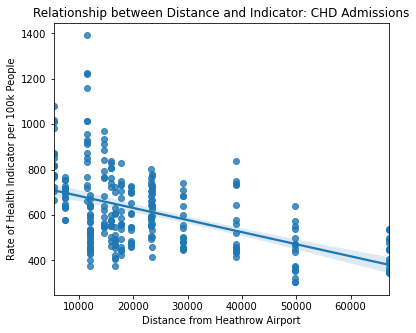

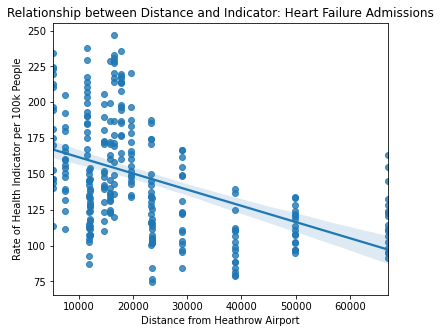

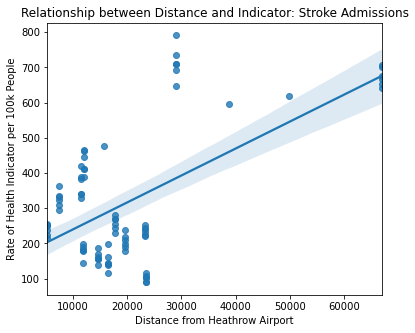

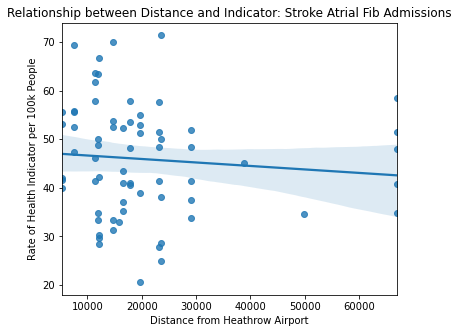

In [14]:
for i in indicators:
    temp_df = health[health["Indicator Name"] == i]
    
    plt.figure(figsize=(6,5))
    sns.regplot(x="heathrow_distance", y="Value", data=temp_df)
    plt.xlabel("Distance from Heathrow Airport")
    plt.ylabel("Rate of Health Indicator per 100k People")
    title = 'Relationship between Distance and Indicator: ' + i
    plt.title(title)

### P-values 

In [15]:
for i in indicators:
    temp_df = health[health["Indicator Name"] == i]
    
    print('Outputting regression summary results for distance and ' + i + '\n')
    X = temp_df["heathrow_distance"]
    Y = temp_df["Value"]
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    print(est2.summary())

Outputting regression summary results for distance and Under 75 Resp Disease

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     65.24
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           9.23e-15
Time:                        19:43:04   Log-Likelihood:                -1127.1
No. Observations:                 376   AIC:                             2258.
Df Residuals:                     374   BIC:                             2266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

Outputting regression summary results for distance and Atrial Fibrillation Prevalence

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     40.96
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           1.41e-09
Time:                        19:43:04   Log-Likelihood:                -53.454
No. Observations:                 175   AIC:                             110.9
Df Residuals:                     173   BIC:                             117.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     84.42
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           1.10e-17
Time:                        19:43:05   Log-Likelihood:                -1751.7
No. Observations:                 272   AIC:                             3507.
Df Residuals:                     270   BIC:                             3515.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               737.4041     16.07

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [6]:
health_wide = pd.read_csv('../data_final/health_data_final_wide_format.csv')
health_wide.head()

,Unnamed: 0,Year,Area Name,Radius Location,heathrow_distance,CCG_Poll_Map,LAT,LONG,<75 Coronary Heart Disease Mortality Rate,Asthma Admissions Over 19yr,...,Hypertension Prevalence,Pneumonia (all mentions) Mortality Rate,Pneumonia Admissions,Respiratory Admissions,Respiratory Tract Admissions 1yr,Respiratory Tract Admissions U1yr,Stroke Admissions,Stroke Atrial Fib Admissions,Stroke: Prevalence,Under 75 Resp Disease Mortality Rate
0,0,2003,NHS Berkshire West CCG,Outer,49791.74229,Reading,51.4458,-1.16963,57.82,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2003,NHS Brent CCG,Outer,16247.54245,No Pollution Readings,51.5644,-0.27568,76.04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2003,NHS Buckinghamshire CCG,Outer,38818.06153,No Pollution Readings,51.7414,-0.80644,51.21,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2003,NHS Croydon CCG,Outer,28645.84070,No Pollution Readings,51.3660,-0.07761,65.63,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2003,NHS Ealing CCG,Inner,11465.53093,Ealing,51.5244,-0.31405,82.91,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:

filt = [
 '<75 Coronary Heart Disease Mortality Rate',
 'Asthma Admissions Over 19yr',
 'Asthma Admissions Under 19yr',
 'Asthma Mortality Rate',
 'Asthma Prevalence',
 'Atrial Fibrillation Prevalence',
 'CHD Admissions',
 'CHD Prevalence',
 'CKD Prevalence',
 'COPD (contributory cause) Mortality Rate',
 'COPD Admissions',
 'COPD Prevalence',
 'Diabetes Prevalence',
 'Heart Failure Admissions',
 'Heart Failure Prevalence',
 'Hypertension Prevalence',
 'Pneumonia (all mentions) Mortality Rate',
 'Pneumonia Admissions',
 'Respiratory Admissions',
 'Respiratory Tract Admissions 1yr',
 'Respiratory Tract Admissions U1yr',
 'Stroke Admissions',
 'Stroke Atrial Fib Admissions',
 'Stroke: Prevalence',
 'Under 75 Resp Disease Mortality Rate',
 'heathrow_distance',
]
health_cols =[
     'Over_75_Coronary_Heart_Disease_Mortality_Rate', 
     'Asthma_Admissions_Over_19yr', 
     'Asthma_Admissions_Under_19yr', 
     'Asthma_Mortality_Rate', 
     'Asthma_Prevalence', 
     'Atrial_Fibrillation_Prevalence', 
     'CHD_Admissions', 'CHD_Prevalence', 
     'CKD_Prevalence', 
     'COPD_contributory_cause_Mortality_Rate', 
     'COPD_Admissions', 
     'COPD_Prevalence', 
     'Diabetes_Prevalence', 
     'Heart_Failure_Admissions', 
     'Heart_Failure_Prevalence', 
     'Hypertension_Prevalence',
     'Pneumonia_all_mentions_Mortality_Rate', 
     'Pneumonia_Admissions',
     'Respiratory_Admissions',
     'Respiratory_Tract_Admissions_1yr', 
     'Respiratory_Tract_Admissions_U1yr',
     'Stroke_Admissions', 
     'Stroke_Atrial_Fib_Admissions',
     'Stroke_Prevalence', 
     'Under_75_Resp_Disease_Mortality_Rate', 
]


health_wide_table  = health_wide[filt]

## Generating Regression Table for Health & Distance

In [8]:
def create_regression_table_v1(df, indicators, x_variable):
    # v1, works with many y values and one x variable column (e.g. distance...)
    # v2 will need to tweak the xvariable into a list or something...
    
    list_o_test_frames = []
    
    # remove characters not supported by OLD model input
    cols = [x.replace(' ', '_').replace('(', '').replace(')', '').replace('<', 'Over_').replace(':', '').replace('.', '') for x in df.columns.tolist()]
    df.columns = cols

    OUTPUT_COLS = ['Indicator Name', 'R Squared', 'Correlation Coef (R)', 'Coefficient Name', 'Coefficient Value', 'P Value', 'Significance (5%)']

    for indicator in indicators:
        print('Running regression for {0} against Flights'.format(indicator))

        tmp = df.copy()[[indicator, x_variable]].dropna()

        model2 = '{0}~{1}'.format(indicator, x_variable)
        lm2    = ols(formula = model2, data= tmp).fit()

        err_series = lm2.params - lm2.conf_int()[0]
        coef_df = pd.DataFrame({'Coefficient Value': lm2.params.values[1:],
                                'P Value': lm2.pvalues.round(4).values[1:],
                                'Coefficient Name': err_series.index.values[1:],
                               })
        coef_df['Indicator Name'] = indicator
        coef_df['R Squared'] = lm2.rsquared
        
        # get correct sign for coefficient
        coef_df['Correlation Coef (R)'] = np.where( 
            coef_df['Coefficient Value']>0,  
            np.sqrt(coef_df['R Squared']), 
            (np.sqrt(coef_df['R Squared']) * -1)
        )
        
        coef_df['Significance (5%)'] = np.where(coef_df['P Value']< 0.05, 'Significant', 'Not Significant')
        
        coef_df = coef_df.round(3)

        list_o_test_frames.append(coef_df[OUTPUT_COLS])


    multi_regression = pd.concat(list_o_test_frames, axis=0)
    multi_regression= multi_regression.reset_index().drop(columns='index')
    return(multi_regression)

In [9]:
print("GENERATING RUN FOR HEALTH AND DISTANCE FROM HEATHROW")
letmeseeplz = create_regression_table_v1(
    health_wide_table,
    health_cols,
    'heathrow_distance'
)


letmeseeplz.to_csv('regression_table_output/health_distance_stations_linreg.csv', encoding='utf-8')

letmeseeplz


GENERATING RUN FOR HEALTH AND DISTANCE FROM HEATHROW
Running regression for Over_75_Coronary_Heart_Disease_Mortality_Rate against Flights
Running regression for Asthma_Admissions_Over_19yr against Flights
Running regression for Asthma_Admissions_Under_19yr against Flights
Running regression for Asthma_Mortality_Rate against Flights
Running regression for Asthma_Prevalence against Flights
Running regression for Atrial_Fibrillation_Prevalence against Flights
Running regression for CHD_Admissions against Flights
Running regression for CHD_Prevalence against Flights
Running regression for CKD_Prevalence against Flights
Running regression for COPD_contributory_cause_Mortality_Rate against Flights
Running regression for COPD_Admissions against Flights
Running regression for COPD_Prevalence against Flights
Running regression for Diabetes_Prevalence against Flights
Running regression for Heart_Failure_Admissions against Flights
Running regression for Heart_Failure_Prevalence against Flights
Ru

,Indicator Name,R Squared,Correlation Coef (R),Coefficient Name,Coefficient Value,P Value,Significance (5%)
0,Over_75_Coronary_Heart_Disease_Mortality_Rate,0.102,-0.320,heathrow_distance,-0.000,0.000,Significant
1,Asthma_Admissions_Over_19yr,0.139,-0.373,heathrow_distance,-0.001,0.000,Significant
2,Asthma_Admissions_Under_19yr,0.051,-0.226,heathrow_distance,-0.000,0.027,Significant
3,Asthma_Mortality_Rate,0.001,-0.030,heathrow_distance,-0.000,0.660,Not Significant
4,Asthma_Prevalence,0.461,0.679,heathrow_distance,0.000,0.000,Significant
5,Atrial_Fibrillation_Prevalence,0.191,0.438,heathrow_distance,0.000,0.000,Significant
6,CHD_Admissions,0.238,-0.488,heathrow_distance,-0.005,0.000,Significant
7,CHD_Prevalence,0.066,0.256,heathrow_distance,0.000,0.001,Significant
8,CKD_Prevalence,0.201,0.448,heathrow_distance,0.000,0.000,Significant
9,COPD_contributory_cause_Mortality_Rate,0.035,-0.187,heathrow_distance,-0.000,0.004,Significant


# Conclusions 

**Pearson’s Correlation Coefficient:** None of the health indicators are strongly correlated (positively or negatively) with distance from the airport. For most health indicators and distance from the airport, -0.5<R<0.5. Three health indicators are mildly positively correlated with distance: Asthma prevalence (R=0.68), stroke prevalence (R=0.58), and stroke admissions (R=0.61). These indicators are worse further away from the airport (opposite of our team’s expected relationship).

**Linear Regression Models and p-values:** The null hypothesis was rejected for every indicator except “asthma mortality rate”, “stroke atrial fib admissions”, and “respiratory tract admissions 1 yr”. The p-value for the remaining 22 indicators was <0.05. 
The following health outcomes (mostly admissions and mortality) are worse closer to the airport: 
- Under 75 Respiratory Disease Mortality rate
- Pneumonia mortality 
- COPD mortality 
- <75 coronary heart disease mortality  
- Diabetes prevalence 
- COPD admissions 
- Respiratory admissions 
- Asthma admissions over 19y 
- Asthma admissions under 19y 
- Pneumonia admissions 
- CHD admissions 
- Heart failure admissions 

The following health outcomes (mostly prevalence) are worse further from the airport: 
- Hypertension prevalence 
- CHD prevalence 
- Heart failure prevalence 
- CKD prevalence 
- Stroke prevalence 
- Atrial fibrillation prevalence 
- COPD prevalence 
- Asthma prevalence 
- Respiratory tract admissions U1yr 
- Stroke admissions 

We observe a pattern where many conditions are more prevalent further from the airport, but closer to the airport, people are admitted to hospitals and die at higher rates. Some of the strongest relationships can be observed in these visualizations

**T-test:** There was a statistically significant difference between health indicators in our “Inner/Outer Radius” designation for the following (15 out of 25) indicators: 
- Under 75 Resp Disease mortality 
- Pneumonia (all mentions) mortality 
- COPD (contributory cause) mortality 
- <75 Coronary Heart Disease mortality 
- Asthma mortality 
- Diabetes Prevalence 
- Heart Failure Prevalence 
- CKD Prevalence 
- Stroke: Prevalence 
- Atrial Fibrillation Prevalence
- COPD Prevalence 
- Asthma Prevalence 
- Asthma Admissions 
- CHD Admissions 
- Heart Failure Admissions 
